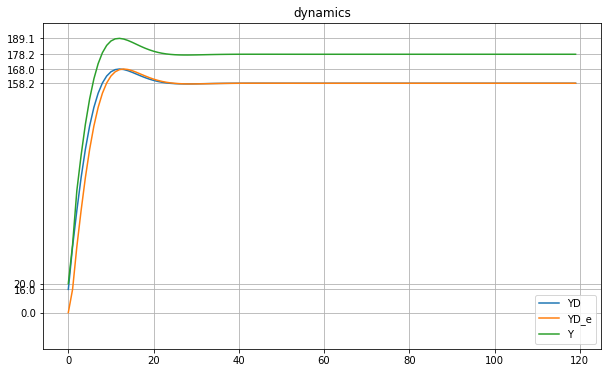

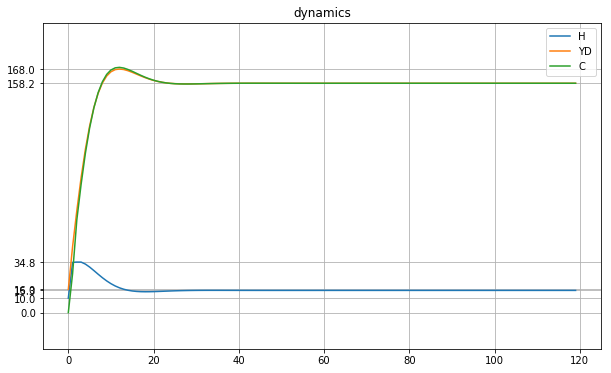

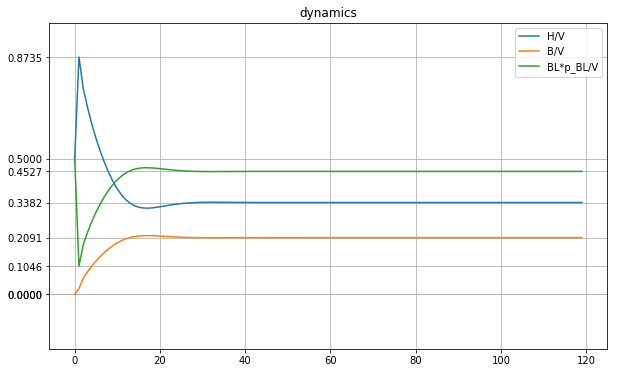

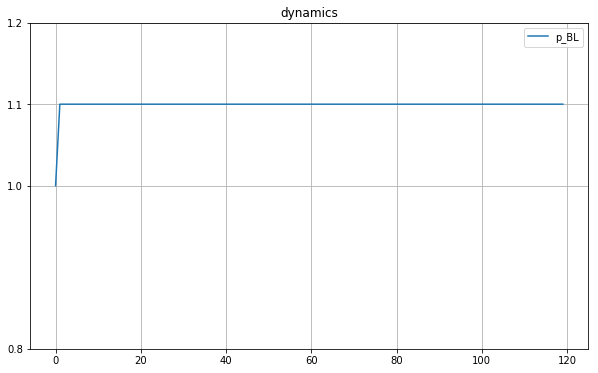

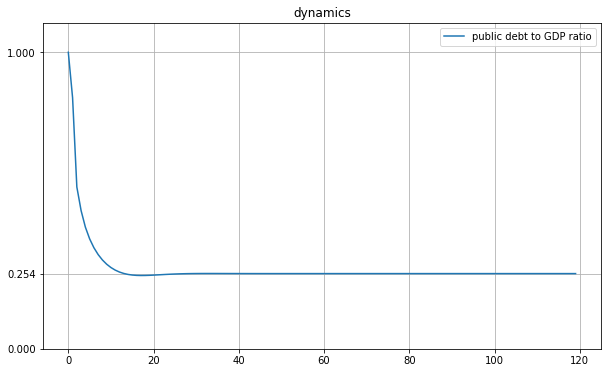

Enter the period to show the balance sheet and transaction matrix:2

Balance Sheet at period:  1
                    Household    Production    Government    Central Bank    Sum
------------------  -----------  ------------  ------------  --------------  -----
Money               34.63        0.00          0.00          -34.63          0.00
Bills               0.87         0.00          -35.50        34.63           0.00
Bonds               4.14         0.00          -4.14         0.00            0.00
Balance(net worth)  -39.64       0.00          39.64         0.00            0.00
sum                 0.00         0.00          0.00          0.00            0.00

Transaction flow matrix at period:  1
--------------------------  ---------  ----------  ----------  ------------  ------------  -----
                                                               Central Bank  Central Bank
                            Household  Production  Government  Current       Capital       Sum
________

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  8 14:46:56 2017
Last modified on Thu Jun  8 14:46:56 2017

@author: Patrick X. Li

@email: xihao.li@gmail.com
"""


#### Model LPEX = Liquidity Preference + Expectation ####
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6

"""
Methods used in the following codes
"""
Error_tolerance = 0.001;

def round_2(n1 ):
    if np.isscalar(n1):
        return np.round(  int( n1*1000 ) /1000, 2 );
    else:
        n2 = np.array(n1) * 1000;
        return np.round(  n2.astype(int) /1000, 2 );


def scalar_approximate_equal(n1, n2):
    if np.isscalar(n1) and np.isscalar(n2):
        if n2 != 0:
            return (abs(n1/n2 - 1) < Error_tolerance)
        elif n1 != 0:
            return (abs(n2/n1 - 1) < Error_tolerance)
        else:
            return True
    else:
        return False

"""
simulation parameter
"""
script_file_full_name = os.path.basename(sys.argv[0]);
script_file_name =  os.path.splitext(script_file_full_name)[0] + "_";
    
end_periods = 120
unit_test_activate = 0;
"""
Economic system variables
"""
theta = 0.2;
alpha_1 = 0.8;
alpha_2 = 0.7;

lambda_10 = 0.9; # portion of expected net worth going to Household's money demand
lambda_20 = 0.05; # portion of expected net worth going to Household's bills demand
lambda_30 = 0.05; # portion of expected net worth going to Household's bonds demand

lambda_11 = 0.5;  lambda_12 = -0.3; lambda_13 = -0.2;
lambda_21 = -0.3; lambda_22 = 0.4;  lambda_23 = -0.1;
lambda_31 = -0.2; lambda_32 = -0.1; lambda_33 = 0.3;

lambda_14 = -0.1;
lambda_24 = 0.06;
lambda_34 = 0.04;

bar_p_BL = 1.1; # Government's target on the price of bonds
bar_r = 0.1; # Government's target on the interest rate of bills                 
chi = 1.2; # Household's parameter on expectational rule for rate of return of Government's bond
class Household:
    """
    Stock variable in Balance Sheet
    """
    H = np.zeros(end_periods); # Household's money demand
    B = np.zeros(end_periods); # Household's treasury bill demand
    BL = np.zeros(end_periods); # Household's bond demand
    V = np.zeros(end_periods); # Household's net worth
    """
    Flow variables in Transactions-flow matrix
    """   
    C = np.zeros(end_periods); # Household's consumption demand
    Y = np.zeros(end_periods); # Household's income in aggregate demand side
    YD = np.zeros(end_periods); # Household's disposable income in aggregate demand side
    
    YD_e = np.zeros(end_periods); # at the beginning of period, Household's expectation on disposable income in aggregate demand side
    V_e = np.zeros(end_periods); # at the beginning of period, Household's expectation on Household's net worth
    p_BL_e = np.ones(end_periods); # at the beginning of period, Household's expectation on Government's price of bonds
    r_BL_e = np.ones(end_periods); # at the beginning of period, Household's expectation on the rate of return on Government's bonds
    CG_e = np.zeros(end_periods); # at the beginning of period, Household's expected Capital Loss/Gain for the current period
    
    T = np.zeros(end_periods); # Household's tax supply
    delta_H = np.zeros(end_periods); # change of Household's money demand
    delta_B = np.zeros(end_periods); # change of Household's treasury bill demand
    delta_BL = np.zeros(end_periods); # change of Household's bond demand
    CG = np.zeros(end_periods); # Household's Capital Loss/Gain
    interest_BL = np.zeros(end_periods); # Household's recieved interest payment on bonds
class Production:
    """
    Flow variables in Transactions-flow matrix
    """       
    C = np.zeros(end_periods); # Production's consumption supply
    G = np.zeros(end_periods); # Production's Government spending supply
    Y = np.zeros(end_periods); # Production's production in aggregate supply side

class CentralBank:
    """
    Stock variable in Balance Sheet
    """    
    H = np.zeros(end_periods); # Central Bank's money supply
    B = np.zeros(end_periods); # Central Bank's treasury bill demand
    """
    Flow variables in Transactions-flow matrix
    """     
    P = np.zeros(end_periods); # Central Bank's profit
    delta_H = np.zeros(end_periods); # change of Central Bank's money supply
    delta_B = np.zeros(end_periods); # change of Central Bank's treasury bill demand

class Government:
    """
    Stock variable in Balance Sheet
    """    
    B = np.zeros(end_periods); # Government's treasury bill supply
    BL = np.zeros(end_periods); # Government's bond supply
    V = np.zeros(end_periods); # Government's net worth    
    """
    Flow variables in Transactions-flow matrix
    """   
    G = np.zeros(end_periods); # Government's spending demand
    CB_P = np.zeros(end_periods); # Government's receiving Central Bank's profit
    T = np.zeros(end_periods); # Government's tax demand
    delta_B = np.zeros(end_periods); # change of Government's treasury bill supply    
    interest_BL = np.zeros(end_periods); # Household's paid interest payment on bonds
    delta_BL = np.zeros(end_periods); # change of Government's bond supply
    CG = np.zeros(end_periods); # Government's Capital Gain/Loss    
    """
    Economic variables
    """
    r = np.ones(end_periods); # Government's government bill interest rate
    p_BL = np.ones(end_periods); # Government's government bond price
    r_BL = np.ones(end_periods); # Government's rate of return on government bond


#== initialize the value of YD[0] ==#
Government.G[0] = 20;
Government.B[0] = Government.G[0] * 0.5; # Government issues treasury bill to support 50% its government spending
Government.BL[0] = Government.G[0] * 0.5 /Government.p_BL[0]; # Government issues bond to support 50% its government spending
CentralBank.B[0] = Government.B[0]; # Central Bank buys all treasury bill issued by government
CentralBank.H[0] = CentralBank.B[0];
Household.H[0] = CentralBank.H[0];
Household.BL[0] = Government.BL[0];
Household.V[0] = Household.H[0] + Household.B[0] + Household.BL[0] * Government.p_BL[0];
Government.V[0] = Government.B[0] + Government.BL[0] * Government.p_BL[0];


Household.Y[0] = Government.G[0] + Household.C[0];
Household.T[0] = theta * Household.Y[0];
Household.YD[0] = Household.Y[0] - Household.T[0];

for t in range(1,end_periods):
    """
    Government decides its spending, the interest rate of treasury bills
    """
    Government.G[t] = Government.G[t-1];
    Government.r[t] = bar_r;
    """
    Household makes expectation on disposable income: YD_e
    """
    Household.YD_e[t] = Household.YD[t-1]; # Household's expectation on its YD
    """
    Based on expectation, Household decides demand for consumption: C
    """
    Household.C[t] = alpha_1 * Household.YD_e[t] + alpha_2 * Household.V[t-1]; # Household's consumption demand, based on its expectation on    
        
    """
    Household makes expectation on price of bonds: p_BL_e, expected capital gain: CG_e, net worth: V_e
    """    
    Household.p_BL_e[t] = Government.p_BL[t-1]; 
    Household.CG_e[t] = chi * ( Household.p_BL_e[t] - Government.p_BL[t-1] ) * Household.BL[t-1];
    Household.V_e[t] = Household.V[t-1] + ( Household.YD_e[t] - Household.C[t] ) + Household.CG_e[t]; # expectational rule of Household's net worth 
    
    Household.r_BL_e[t] = Government.r_BL[t-1] + chi * ( Household.p_BL_e[t] - Government.p_BL[t-1] ) / Government.p_BL[t-1];
    """
    Based on expectation, Household decides demand for treasury bill, 
    demand for bonds, demand for money: B, BL, H
    """
    Household.B[t] = lambda_20 * Household.V_e[t] + lambda_22 * Government.r[t] * Household.V_e[t] + lambda_23 * Household.r_BL_e[t] * Household.V_e[t] + lambda_24 * Household.YD_e[t];
    Household.BL[t] = 1/ Household.p_BL_e[t] * ( lambda_30 * Household.V_e[t] + lambda_32 * Government.r[t] * Household.V_e[t] + lambda_33 * Household.r_BL_e[t] * Household.V_e[t] + lambda_34 * Household.YD_e[t] );
    Household.H[t] = Household.V_e[t] - Household.B[t] - Household.p_BL_e[t] * Household.BL[t];
    
    """
    Production realizes supply = demand
    """
    Production.G[t] = Government.G[t];
    Production.C[t] = Household.C[t];
    Production.Y[t] = Production.G[t] + Production.C[t];
    """
    Household realizes its production, tax payment                                       
    """
    Household.Y[t] = Production.Y[t];
    Household.T[t] = theta * ( Household.Y[t] + Government.r[t-1] * Household.B[t-1] + Household.BL[t-1] );
    """
    Government collects tax
    """
    Government.T[t] = Household.T[t];
    """
    Household realizes its disposable income                                 
    """
    Household.YD[t] = Household.Y[t] - Household.T[t] + Government.r[t-1] * Household.B[t-1] + Household.BL[t-1];
    """
    Government decides the price of bonds, computes the rate of return of bonds
    """
    Government.p_BL[t] = bar_p_BL;
    Government.r_BL[t] = 1/Government.p_BL[t];    
    """
    Household computes its capital gain
    """
    Household.CG[t] = ( Government.p_BL[t] - Government.p_BL[t-1] ) * Household.BL[t-1];
         
    """
    Household realizes its net worth                                 
    """
    Household.V[t] = Household.V[t-1] + ( Household.YD[t] - Household.C[t] ) + Household.CG[t];
    
    """
    Household adjusts, at the end of period, any discrepency 
    between realized net worth and treasury bill demand and bonds demand, 
    putting it as money demand 
    """
    Household.H[t] = Household.V[t] - Household.B[t] - Government.p_BL[t] * Household.BL[t]; 
    Household.delta_H[t] = Household.H[t] - Household.H[t-1];

    """
    Government decides its new level of treasury bill supply, bonds supply    
    """
    Government.BL[t] = Household.BL[t];
    Government.delta_BL[t] = Government.BL[t] - Government.BL[t-1];  
    
    CentralBank.P[t] = Government.r[t-1] * CentralBank.B[t-1];
    Government.CB_P[t] = CentralBank.P[t];      
    Government.delta_B[t] = (Government.G[t] + Government.r[t-1] * Government.B[t-1] + Government.BL[t-1]) - (Government.T[t] + Government.CB_P[t]) - Government.delta_BL[t] * Government.p_BL[t];
    Government.B[t] = Government.B[t-1] + Government.delta_B[t];
    
    Government.V[t] = Government.B[t] + Government.BL[t] * Government.p_BL[t];    
    """
    CentralBank collects the residual of treasury bill in the market:
    the difference between Government's bill supply and Household's bill demand
    """
    CentralBank.B[t] = Government.B[t] - Household.B[t];
    """
    CentraBank decides its new level of money supply based on its change of treasury bill bought in
    """    
    CentralBank.delta_B[t] = CentralBank.B[t] - CentralBank.B[t-1];
    CentralBank.delta_H[t] = CentralBank.delta_B[t];
    CentralBank.H[t] = CentralBank.H[t-1] + CentralBank.delta_H[t];
    """
    Household computes its change of treasury bill, its change of bonds, to check stock-flow consistency 
    """
    Household.delta_B[t] = Household.B[t] - Household.B[t-1];
    Household.delta_BL[t] = Household.BL[t] - Household.BL[t-1];
    
    # unit test on stock-flow consistency
    if unit_test_activate == 1:
        if scalar_approximate_equal(Government.delta_B[t] , Household.delta_B[t] + CentralBank.delta_B[t] ):
            print('Consistency check: change of Bill supply == change of Bill demand');
        else:
            print('Warning! change of Bill supply == change of Bill demand INconsistency!'); 

# plot Household expectation on disposable income, realized disposable income, 
# and total income == GDP in demand side
plot_period = end_periods + 1
plt.figure(1)
plt.plot(Household.YD, label = 'YD')
plt.plot(Household.YD_e, label = 'YD_e')
plt.plot(Household.Y, label = 'Y')
plt.title('dynamics')
plt.legend(['YD', 'YD_e', 'Y'], loc=0) # legend automatically in the best location
extraticks=[0.0, Household.YD[end_periods-1], np.min(Household.YD ), np.max(Household.YD ), Household.Y[end_periods-1], np.min(Household.Y), np.max(Household.Y)  ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_01.pdf') 
plt.show()

# plot Household money stock, disposable income, consumption

plot_period = end_periods + 1
plt.figure(2)
plt.plot(Household.H, label = 'H')
plt.plot(Household.YD, label = 'YD')
plt.plot(Household.C, label = 'C')
plt.title('dynamics')
plt.legend(['H', 'YD', 'C'], loc=0) # legend automatically in the best location
extraticks=[0.0, Household.H[end_periods-1], np.min(Household.H), np.max(Household.H), Household.YD[end_periods-1], np.min(Household.YD), np.max(Household.YD) ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_02.pdf') 
plt.show()

# plot Household share of money stock, treasury bills, value of bonds
plot_period = end_periods + 1
plt.figure(2)
plt.plot(Household.H/ Household.V, label = 'H/V')
plt.plot(Household.B/ Household.V, label = 'B/V')
plt.plot(Household.BL * Government.p_BL / Household.V, label = 'BL*p_BL/V')
plt.title('dynamics')
plt.legend(['H/V', 'B/V', 'BL*p_BL/V'], loc=0) # legend automatically in the best location
extraticks=[0.0, Household.H[end_periods-1]/Household.V[end_periods-1],  np.max( Household.H/Household.V), Household.B[end_periods-1]/Household.V[end_periods-1], np.min(Household.B/Household.V), Household.BL[end_periods-1] * Government.p_BL[end_periods-1] /Household.V[end_periods-1], np.min( Household.BL * Government.p_BL /Household.V ), np.max( Household.BL * Government.p_BL /Household.V ) ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_03.pdf') 
plt.show()


# plot government bond price

plot_period = end_periods + 1
plt.figure(2)
plt.plot(Government.p_BL, label = 'p_BL')
plt.title('dynamics')
plt.legend(['p_BL'], loc=0) # legend automatically in the best location
extraticks=[np.min(Government.p_BL ), 0.8, Government.p_BL[end_periods-1], 1.2 ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()

plt.show()


# plot the economy's public debt to GDP ratio: V/Y, V: the wealth of Household, equal to the debt owed by Government
plot_period = end_periods + 1
plt.figure(2)
plt.plot(Household.V/ Household.Y, label = 'V/Y')
plt.title('dynamics')
plt.legend(['public debt to GDP ratio'], loc=0) # legend automatically in the best location
extraticks=[0.0, np.max( Household.V/Household.Y ), Household.V[end_periods-1]/Household.Y[end_periods-1] ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_04.pdf') 
plt.show()

    
while True:
    table_periods = int(input('Enter the period to show the balance sheet and transaction matrix:'))
    if table_periods > end_periods + 1:
        table_periods = end_periods;

    BS_headers = [" ", "Household", "Production", "Government", "Central Bank", "Sum"]
    # balance sheet table
    bs_table = [["Money", Household.H[table_periods-1], 0.0, 0.0, - CentralBank.H[table_periods-1], sum( [ Household.H[table_periods-1], - CentralBank.H[table_periods-1] ] )], 
                ["Bills", Household.B[table_periods-1], 0, - Government.B[table_periods-1], + CentralBank.B[table_periods-1], sum([ Household.B[table_periods-1], 0, - Government.B[table_periods-1], + CentralBank.B[table_periods-1] ])  ],
                ["Bonds", Household.BL[table_periods-1] * Government.p_BL[table_periods-1], 0, - Government.BL[table_periods-1] * Government.p_BL[table_periods-1], 0, sum([ Household.BL[table_periods-1] * Government.p_BL[table_periods-1], 0, - Government.BL[table_periods-1] * Government.p_BL[table_periods-1] ])  ],
                
                ["Balance(net worth)", - Household.V[table_periods-1], 0.0, +Government.V[table_periods-1], 0.0 , sum([ - Household.V[table_periods-1], 0.0, +Government.V[table_periods-1]  ])  ],
                ["sum", sum([ Household.H[table_periods-1],  Household.B[table_periods-1], Household.BL[table_periods-1] * Government.p_BL[table_periods-1], - Household.V[table_periods-1] ]), 0.0, sum( [ - Government.B[table_periods-1], - Government.BL[table_periods-1] * Government.p_BL[table_periods-1], +Government.V[table_periods-1] ] ), sum([- CentralBank.H[table_periods-1], + CentralBank.B[table_periods-1]  ]), sum([ sum([ Household.H[table_periods-1],  Household.B[table_periods-1], Household.BL[table_periods-1] * Government.p_BL[table_periods-1], - Household.V[table_periods-1] ]), 0.0, sum( [ - Government.B[table_periods-1], - Government.BL[table_periods-1] * Government.p_BL[table_periods-1], +Government.V[table_periods-1] ] ), sum([- CentralBank.H[table_periods-1], + CentralBank.B[table_periods-1]  ]) ])  ]
                ]
    print("\nBalance Sheet at period: ", table_periods-1)
    print(tabulate(bs_table, BS_headers, floatfmt=".2f", numalign="left") )
    
    
    # transaction flow table
    tf_headers = [" ",  " ", " ",  " ", "Central Bank", "Central Bank", " "];
    
    sum_row_1 = round_2(sum([ round_2(-Household.C[table_periods-1]), round_2(+Production.C[table_periods-1]) ]) );
    sum_row_2 = round_2(sum([ round_2(+Production.G[table_periods-1]), round_2(-Government.G[table_periods-1]) ]) );
    sum_row_3 = round_2(sum([ round_2( Household.Y[table_periods-1] ), round_2( -Production.Y[table_periods-1] ) ]) );
    sum_row_4 = round_2(sum([ round_2(+ Government.r[table_periods-1-1] * Household.B[table_periods-1-1] ), round_2(- Government.r[table_periods-1-1] * Government.B[table_periods-1-1] ), round_2(+ Government.r[table_periods-1-1] * CentralBank.B[table_periods-1-1] ) ]) );
    sum_row_5 = round_2(sum([ round_2(+ Household.BL[table_periods-1-1] ), round_2(- Government.BL[table_periods-1-1] ) ]) );
    sum_row_6 = round_2(sum([ round_2( + Government.CB_P[table_periods -1] ), round_2( -CentralBank.P[table_periods-1] ) ]) );
    sum_row_7 = round_2(sum([ round_2(-Household.T[table_periods-1] ), round_2(+Government.T[table_periods-1] ) ]) )
    sum_row_8 = round_2(sum([ round_2(-Household.delta_H[table_periods-1] ), round_2(+CentralBank.delta_H[table_periods-1] ) ]) )
    sum_row_9 = round_2(sum([ round_2( -Household.delta_B[table_periods-1] ), round_2( +Government.delta_B[table_periods-1] ), round_2( -CentralBank.delta_B[table_periods-1] ) ]) )
    sum_row_10 = round_2( sum([ round_2( -Household.delta_BL[table_periods-1] * Government.p_BL[table_periods-1] ), round_2( +Government.delta_BL[table_periods-1] * Government.p_BL[table_periods-1] ) ]) )
    
    sum_column_1 = round_2(sum( round_2([ -Household.C[table_periods-1], Household.Y[table_periods-1], + Government.r[table_periods-1-1] * Household.B[table_periods-1-1], + Household.BL[table_periods-1-1] , -Household.T[table_periods-1] , -Household.delta_H[table_periods-1], -Household.delta_B[table_periods-1], - Household.delta_BL[table_periods-1] * Government.p_BL[table_periods-1] ]) ) )
    sum_column_2 = round_2(sum( round_2([ Production.C[table_periods-1], Production.G[table_periods-1], - Production.Y[table_periods-1] ]) ) )
    sum_column_3 = round_2(sum( round_2([ -Government.G[table_periods-1], - Government.r[table_periods-1-1] * Government.B[table_periods-1-1] , -Government.BL[table_periods-1-1] , + Government.CB_P[table_periods-1], + Government.T[table_periods-1], + Government.delta_B[table_periods-1], + Government.delta_BL[table_periods-1] * Government.p_BL[table_periods-1]   ]) ) )
    sum_column_4 = round_2(sum( round_2([ +Government.r[table_periods-1-1] * CentralBank.B[table_periods-1-1] , - CentralBank.P[table_periods-1]  ]) ) )
    sum_column_5 = round_2(sum( round_2([ +CentralBank.delta_H[table_periods-1], - CentralBank.delta_B[table_periods-1] ]) ) )
    sum_all_columns = round_2(sum( round_2([sum_column_1, sum_column_2, sum_column_3, sum_column_4, sum_column_5]) ) )
    
    sum_row_11 = round_2(sum( [ round_2( -Household.BL[table_periods-1-1] * ( Government.p_BL[table_periods-1] - Government.p_BL[table_periods-1-1]) ), round_2( + Government.BL[table_periods-1-1] * ( Government.p_BL[table_periods-1] - Government.p_BL[table_periods-1-1]) ) ] )  )
    
    tf_table = [[" ",  " ", " ",  " ", "Central Bank", "Central Bank", " "],
                [" ", "Household", "Production", "Government", " Current ", " Capital ", "Sum"],
                [ "__________________", "_________", "_________", "_________", "_________", "_________", "_____" ],
                ["Consumption", round_2(-Household.C[table_periods-1]), round_2(+Production.C[table_periods-1]), " ", " ", " ", sum_row_1 ],
    ["Govt. expenditures", " " , round_2(+Production.G[table_periods-1]), round_2(-Government.G[table_periods-1]), " ", " ",  sum_row_2 ],
    ["Income = GDP", round_2( Household.Y[table_periods-1] ), round_2( -Production.Y[table_periods-1] ),  " ", " ", " ", sum_row_3 ],
    ["Interest payments on bills", round_2(+ Government.r[table_periods-1-1] * Household.B[table_periods-1-1] ), " ", round_2(- Government.r[table_periods-1-1] * Government.B[table_periods-1-1] ), round_2(+ Government.r[table_periods-1-1] * CentralBank.B[table_periods-1-1] ),  " ", sum_row_4 ],
    ["Interest payments on bonds", round_2(+ Household.BL[table_periods-1-1] ), " ", round_2(- Government.BL[table_periods-1-1] ), " ",  " ", sum_row_5  ],
    ["Central bank profits", " ", " ", round_2( + Government.CB_P[table_periods -1] ), round_2( -CentralBank.P[table_periods-1] ), " ", sum_row_6 ],
    ["Taxes", round_2(-Household.T[table_periods-1] ), " ", round_2(+Government.T[table_periods-1] ), " ", " ", sum_row_7 ],
    ["Change in money", round_2(-Household.delta_H[table_periods-1] ), " ", " ", " ", round_2(+CentralBank.delta_H[table_periods-1] ), sum_row_8 ],
    ["Change in bills", round_2( -Household.delta_B[table_periods-1] ), " ", round_2( +Government.delta_B[table_periods-1] ), " ", round_2( -CentralBank.delta_B[table_periods-1] ), sum_row_9 ],
    ["Change in bonds", round_2( -Household.delta_BL[table_periods-1] * Government.p_BL[table_periods-1] ), " ", round_2( +Government.delta_BL[table_periods-1] * Government.p_BL[table_periods-1] ), " ", " ", sum_row_10 ],
    [ "__________________", "_________", "_________", "_________", "_________", "_________", "_____" ],
    ["sum", sum_column_1, sum_column_2, sum_column_3, sum_column_4, sum_column_5, sum_all_columns ], 
    ["Capital Gains", round_2( -Household.BL[table_periods-1-1] * ( Government.p_BL[table_periods-1] - Government.p_BL[table_periods-1-1]) ), " ", round_2( + Government.BL[table_periods-1-1] * ( Government.p_BL[table_periods-1] - Government.p_BL[table_periods-1-1]) ), " ", " ", sum_row_11 ]
    ]
    print("\nTransaction flow matrix at period: ", table_periods-1)
    print(tabulate(tf_table, floatfmt=".2f", numalign="left"))
    print("\nEnd of codes!")
    answer = input('Do you want to continue?:')
    if answer.lower().startswith("n"):
      print("ok, bye!")
      break
